# Классификация изображений

Сегодня нам предстоит помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании нам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

## Загрузка данных

In [ ]:
import pickle
import pandas as pd
import numpy as np
from skimage import io
import torch
from collections import Counter

from tqdm import tqdm, tqdm_notebook
from tqdm.autonotebook import tqdm, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import WeightedRandomSampler

import time

from matplotlib import colors, pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
# размер батча
BATCH_SIZE = 128
# количество эпох
EPOCHS = 20

In [ ]:
from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    !nvidia-smi

CUDA is available!  Training on GPU ...
Mon Dec 26 10:58:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |      3MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

Ниже мы исспользуем враппер над датасетом для удобной работы. Нам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных. Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample).

Обработка данных (`__getitem__`):
* Преобразование обучающих данных для расширения обучающей выборки (аугментация) и её нормализация
* Для валидационной (тестовой) выборки только нормализация

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch, аугментации  и нормализации входа
        
        if self.mode == "train":
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE+10, RESCALE_SIZE+10)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Загрузим данные через указанный путь.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/

MyDrive


In [ ]:
!ls -l /content/drive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 24 13:17 /content/drive/MyDrive/journey-springfield.zip


In [ ]:
!unzip -q /content/drive/MyDrive/journey-springfield.zip 

In [ ]:
!ls -1

characters_illustration.png
drive
sample_data
sample_submission.csv
testset
train


In [ ]:
!ls train
!ls testset


simpsons_dataset
testset


In [ ]:
TRAIN_DIR = Path("train/simpsons_dataset")
TEST_DIR = Path("testset/testset")

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


Данные нужно разбить на части. Зафиксируем псевдослучайность для алгоритма обучения, укажем параметр random_state. Укажем параметр stratify, который сохранит пропорции классов для целевого признака во всех выборках.

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state = 123)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')  
test_dataset = SimpsonsDataset(test_files, mode="test")

Посмотрим на наших героев внутри датасета.

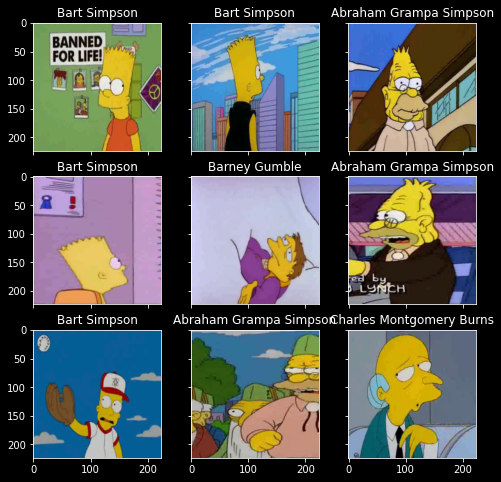

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Мы получили изображения размером 224х224.

Посмотрим на распредление значений по классам.

In [ ]:
train_labels = [path.parent.name for path in train_files]
tr_labels_count = pd.Series(train_labels).value_counts()
tr_labels_count

homer_simpson               1684
ned_flanders                1090
moe_szyslak                 1089
lisa_simpson                1015
bart_simpson                1006
marge_simpson                968
krusty_the_clown             904
charles_montgomery_burns     895
principal_skinner            895
milhouse_van_houten          809
chief_wiggum                 739
abraham_grampa_simpson       685
sideshow_bob                 658
apu_nahasapeemapetilon       467
kent_brockman                373
comic_book_guy               352
edna_krabappel               343
nelson_muntz                 269
lenny_leonard                233
mayor_quimby                 185
waylon_smithers              136
maggie_simpson                96
groundskeeper_willie          91
barney_gumble                 80
selma_bouvier                 77
carl_carlson                  74
ralph_wiggum                  67
patty_bouvier                 54
martin_prince                 53
professor_john_frink          49
snake_jail

Класс (персонаж) «lionel_hutz» встречается реже всего, доля очень мала. Вообще, все герои представлены по-разному. Классы не сбалансированы, когда их соотношение далеко от 1:1. Попробуем подход взвешенного самплера WeightedRandomSampler, который будет выдавать нам батчи, состоящие из классов у которых будут разные вероятности появления - веса.

In [ ]:
class_weights = {label: 1./c for label, c in tr_labels_count.items()}
class_weights
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_1 = train_dataset.label_encoder.inverse_transform([label])[0]
    class_weight = class_weights.get(label_1)
    sample_weights[i] = class_weight


sampler = WeightedRandomSampler(sample_weights, num_samples = 2*len(train_dataset))

  0%|          | 0/15699 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 100, sampler = sampler)
x = pd.DataFrame()
for _, labels in train_loader:
    lbls = [train_dataset.label_encoder.inverse_transform([label])[0] for label in labels]
    label_count = pd.Series(lbls, index=lbls, name='count').value_counts()
    x = x.append(label_count)
    
x = x.fillna(value=0)
y = x.sum(axis = 0)
y

carl_carlson                743.0
professor_john_frink        709.0
comic_book_guy              683.0
lenny_leonard               773.0
homer_simpson               784.0
ralph_wiggum                744.0
abraham_grampa_simpson      735.0
rainier_wolfcastle          720.0
krusty_the_clown            789.0
charles_montgomery_burns    759.0
troy_mcclure                691.0
milhouse_van_houten         749.0
agnes_skinner               729.0
bart_simpson                720.0
edna_krabappel              739.0
marge_simpson               799.0
lionel_hutz                 790.0
chief_wiggum                736.0
sideshow_bob                761.0
apu_nahasapeemapetilon      736.0
principal_skinner           768.0
ned_flanders                788.0
disco_stu                   766.0
groundskeeper_willie        766.0
snake_jailbird              763.0
cletus_spuckler             763.0
barney_gumble               727.0
gil                         695.0
kent_brockman               745.0
nelson_muntz  

Данные корректно отсэмплированы.

## Простая сеть

*Описание слоев*:



1. размерность входа: 3x224x224 
2. размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

Выход модели должен быть такой же, как количество классов в train_val_labels - 42.

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

Обучение модели по эпохам. Мы хотим, чтобы наш learning rate как-то изменялся во время обучения. Стратегия, по которой мы будем изменять lr называется lr scheduilng. На вход функции подаются модель, даталоадер, оптимизатор, scheduler и функция потерь. Функция возвращает лосс и точность после пробега эпохи обучения:
1. input, label на device.
2. Обнулить градиент оптимизатора.
3. Сделать предсказание.
4. Подсчитать лосс
5. backward-pass 
6. шаг оптимизатора
7. Предсказание 
8. Рассчитываем точность и лосс
9. Шаг scheduler
10. Рассчитываем средние точность и лосс

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    model.train(True)
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    if scheduler is not None:
        scheduler.step()
            
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Валидация модели без обучения.

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size # double()
    return val_loss, val_acc

В качестве лосс используем кросс-энтропию. В качестве оптимизатора Adam. Мы хотим, чтобы наш learning rate как-то изменялся во время обучения. Стратегия, по которой мы будем изменять lr называется lr scheduilng.

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, scheduler, opt=None, criterion=None):

    if opt is None:
            opt = torch.optim.Adam(model.parameters())
            
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
        
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    class_count = Counter(train_dataset.labels)          
    class_weights = {i: 1 / (c**0.9 + 6) for i, c in class_count.items()}
    sample_weights = [0] * len(train_dataset)

    for i, label in enumerate(tqdm(train_dataset.labels)):
        class_weight = class_weights[label]
        sample_weights[i] = class_weight

    N = len(train_dataset)  
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if val_acc > best_acc:  
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
            
    return model, history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# Использовать ли GPU
if use_gpu:
    model = simple_cnn.cuda()

# В качестве оптимизатора - Адам
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Умножает learning_rate на 0.5 каждые 5 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
model, history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE, opt=optimizer, scheduler=exp_lr_scheduler)

  0%|          | 0/15699 [00:00<?, ?it/s]

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 3.0428992488352504

Epoch 001 train_loss: 3.0429     val_loss 2.2267 train_acc 0.2068 val_acc 0.4081
loss 1.6663724227926293

Epoch 002 train_loss: 1.6664     val_loss 1.9155 train_acc 0.5634 val_acc 0.5013
loss 1.091898786280518

Epoch 003 train_loss: 1.0919     val_loss 1.5838 train_acc 0.7161 val_acc 0.6032
loss 0.8325308280254187

Epoch 004 train_loss: 0.8325     val_loss 1.3775 train_acc 0.7794 val_acc 0.6425
loss 0.6802035085911492

Epoch 005 train_loss: 0.6802     val_loss 1.2935 train_acc 0.8211 val_acc 0.6794
loss 0.5107134087722509

Epoch 006 train_loss: 0.5107     val_loss 1.1903 train_acc 0.8668 val_acc 0.7016
loss 0.44270696285932915

Epoch 007 train_loss: 0.4427     val_loss 1.1835 train_acc 0.8835 val_acc 0.7155
loss 0.3835050850827585

Epoch 008 train_loss: 0.3835     val_loss 1.2366 train_acc 0.8997 val_acc 0.7094
loss 0.36514194707512376

Epoch 009 train_loss: 0.3651     val_loss 1.1906 train_acc 0.9008 val_acc 0.7211
loss 0.3350791711778092

Epoch 010 train_loss

Качество модели невысокое.

У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

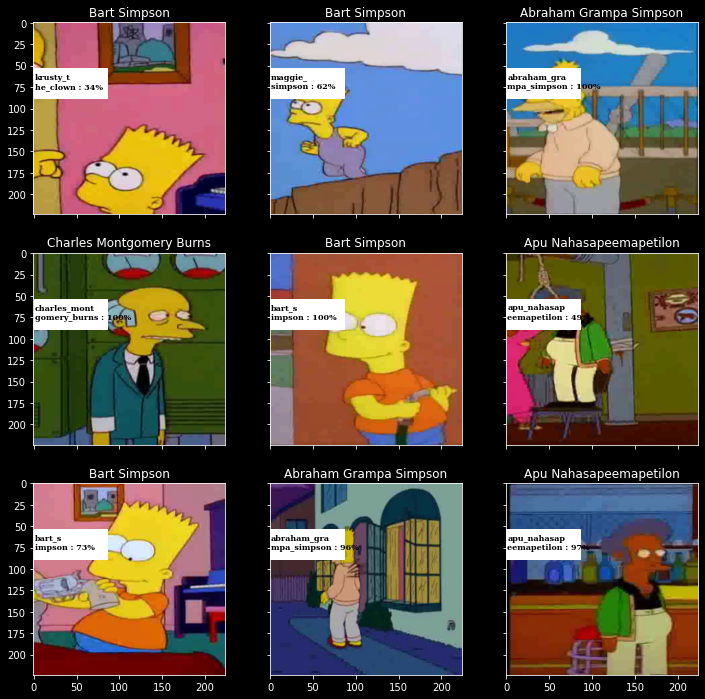

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("serif")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Качество модели невысокое.

## ResNet18

Используем предобученную модель ResNet18.

In [ ]:
model_resnet18 = models.resnet18(pretrained=True).to(DEVICE)
model=model_resnet18

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Мы будем обучать не только последний fully connected слой, но и параметры предпоследнего слоя 4.1. Сделаем так, чтобы на остальные слои не распространялся backpropagation (заморозим их).

Посмотрим, что внутри.

In [ ]:
for name, p in model.named_parameters():
    if name.startswith("layer4.1.") or name.startswith("fc."):
        p.requires_grad = True
    else:
        p.requires_grad = False
    
    print("param name:", name, "requires_grad:", p.requires_grad)

param name: conv1.weight requires_grad: False
param name: bn1.weight requires_grad: False
param name: bn1.bias requires_grad: False
param name: layer1.0.conv1.weight requires_grad: False
param name: layer1.0.bn1.weight requires_grad: False
param name: layer1.0.bn1.bias requires_grad: False
param name: layer1.0.conv2.weight requires_grad: False
param name: layer1.0.bn2.weight requires_grad: False
param name: layer1.0.bn2.bias requires_grad: False
param name: layer1.1.conv1.weight requires_grad: False
param name: layer1.1.bn1.weight requires_grad: False
param name: layer1.1.bn1.bias requires_grad: False
param name: layer1.1.conv2.weight requires_grad: False
param name: layer1.1.bn2.weight requires_grad: False
param name: layer1.1.bn2.bias requires_grad: False
param name: layer2.0.conv1.weight requires_grad: False
param name: layer2.0.bn1.weight requires_grad: False
param name: layer2.0.bn1.bias requires_grad: False
param name: layer2.0.conv2.weight requires_grad: False
param name: layer2

Оптимизатор также распостраняется только на последние 8 параметров, соответственно слою 4.1.

In [ ]:
optimizer = optim.Adam(list(model.parameters())[-8:], lr=1e-3)

In [ ]:
model, history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE, opt=optimizer, scheduler=exp_lr_scheduler)

  0%|          | 0/15699 [00:00<?, ?it/s]

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.7979601471107001

Epoch 001 train_loss: 0.7980     val_loss 0.5299 train_acc 0.8332 val_acc 0.8598
loss 0.1412666485300147

Epoch 002 train_loss: 0.1413     val_loss 0.4639 train_acc 0.9645 val_acc 0.8821
loss 0.09019053805577003

Epoch 003 train_loss: 0.0902     val_loss 0.4545 train_acc 0.9769 val_acc 0.8886
loss 0.06966468684517188

Epoch 004 train_loss: 0.0697     val_loss 0.4267 train_acc 0.9824 val_acc 0.8949
loss 0.04905817419174505

Epoch 005 train_loss: 0.0491     val_loss 0.4048 train_acc 0.9882 val_acc 0.9028
loss 0.0367183819116804

Epoch 006 train_loss: 0.0367     val_loss 0.4026 train_acc 0.9914 val_acc 0.9073
loss 0.027713767919186116

Epoch 007 train_loss: 0.0277     val_loss 0.4041 train_acc 0.9929 val_acc 0.9075
loss 0.019257192179172447

Epoch 008 train_loss: 0.0193     val_loss 0.3762 train_acc 0.9949 val_acc 0.9133
loss 0.017634286461985903

Epoch 009 train_loss: 0.0176     val_loss 0.4031 train_acc 0.9958 val_acc 0.9115
loss 0.022508344476304214

Epoch 010 

Точность на обучении почти максимальная. Построим график лосса при обучении и валидации.

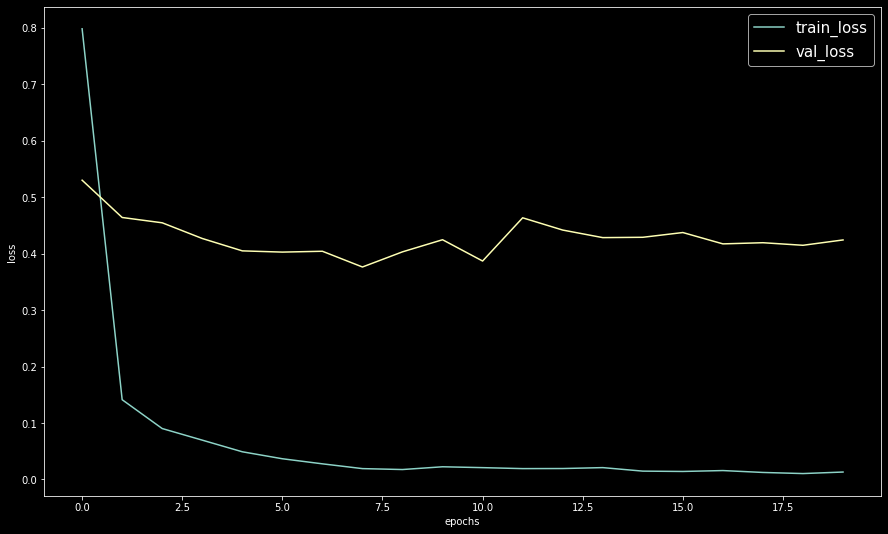

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best', fontsize=15)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Выполним предскзание на тестовой выборке и выгрузим Сабмит для участия в соревновании Кеггл.

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('siimple_baseline.csv', index=False)

Score 0.97024